Notes from Discussion on 30 June:

Communication through Slack group channel
Work on code in Google CoLab notebook
Publishing final code to github repository once complete

Individual Tasks:


*   Create Github repository --Nandi
*   Research Methods --Manasvi
*   Model Implementation:
    *   Framework Selection --Tiffany
    *   Dataset Preparation --Tiffany
    *   Model Development --Murari
    *   Training & Fine-tuning --Murari
    *   Evaluation & Metrics --Nandi
*   Additional Dataset for [Test] --Nandi







Research:
Define Objectives:

Our goal is to develop a Natural Language Processing system that takes in unconsolidated patient data with a lack of structure and converts this into medically standardized descriptions for medical professionals to comprehend and assess symptoms with greater efficiency. Our objectives consist of:

Task: Text Summarization → Symptom Summarization

Objective: Convert free-text, patient messages into brief summaries using standardized medical terminology through natural language processing.

Task Type: Entity Recognition / Span Classification → (NER)Negation Detection

Objective: Extract key medical terminology and illness indicators such as symptoms, body parts, and condition-specific phrases from raw patient input.

Task Type: Sequence Classification / Pattern Recognition → Medical Named Entity Recognition

Objective: Identify when symptoms are negated to avoid incorrect diagnosis suggestions.

Task Type: Multi-class Classification → Symptom-to-Diagnosis Classification

Objective: Predict a preliminary list of potential diagnoses or categorize the case into a relevant department of care based on the summarized symptoms.

Task Type: Terminology Output → Medical Context Mapping

Objective: Map extracted symptom descriptions to standardized codes and medical phrases for consistency and interoperability.

These objectives reflect the mission of improving workflow efficiency for medical professionals while simultaneously structuring patient input for reliable diagnostic support.

Literature Review:

To identify the most suitable NLP methods for symptom notes condensing and diagnosis support, we reviewed recent research papers, model benchmarks, and applied best practices across the following key areas:

1. Text Summarization
Relevant Methods:

BART (Lewis et al., 2020): A denoising autoencoder that has achieved strong results on summarization tasks like CNN/DailyMail.

T5 (Raffel et al., 2020): A flexible text-to-text transformer that performs summarization, translation, and classification by reframing tasks as text generation.

PEGASUS (Zhang et al., 2020): Designed specifically for abstractive summarization, making it well-suited to clinical notes or patient symptom narratives.

Medical-Specific Work:

ClinicalBERT + BART hybrids have been explored for generating discharge summaries from clinical notes.

MedSum and BioBART: Pretrained versions of summarization models on PubMed and clinical note corpora.

2. Named Recognition (NER) for Medical Terms
Relevant Methods:

BioBERT (Lee et al., 2020): Pretrained on large biomedical corpora (PubMed + PMC), excellent for medical NER and relation extraction.

ClinicalBERT (Alsentzer et al., 2019): Fine-tuned on MIMIC-III and clinical notes, better for informal or patient-language variations.

ScispaCy: Lightweight spaCy-based models trained for biomedical and clinical entity detection, often used in pipeline integration.

Clinical Use Cases: Extraction of entities such as symptoms, diseases, drug mentions, and body locations from patient-reported inputs.

3. Negation Detection

Key Approaches:

NegEx (Chapman et al., 2001): A rule-based system used for detecting negated terms in clinical text.

ConText: An extension of NegEx that adds temporality and experiencer detection.

BiLSTM + CRF or Transformer-based NER models with negation-specific tagging schemes.

4. Symptom-to-Diagnosis Prediction
Popular Models:

Traditional ML: Logistic Regression, Random Forest (baseline approaches for multiclass prediction).

Deep Learning: CNNs for symptom text classification.

Transformer Classifiers: Fine-tuned BioBERT or RoBERTa models for direct disease classification.

Long-shot Approaches:

Useful due to limited clinical datasets. Prompt-based learning using T5 or GPT-3/4 to classify unseen symptom patterns.

5. Terminology Standardization

QuickUMLS, MetaMap, cTAKES: Tools that match extracted phrases to UMLS or SNOMED CT.

BioSyn (Sung et al., 2020): A biomedical model that maps terms to standardized vocabularies using contrastive learning.

Benchmarking:

To choose the most fitting NLP techniques for this project, we evaluated models based on accuracy, efficiency, and domain relevance. Our goals include summarizing symptoms, extracting medical terms, detecting negation, predicting diagnoses, and mapping terminology to medical vocabularies to generate an output that reads.

For symptom summarization, models like T5 and BART offer strong general-purpose performance and can be fine-tuned for medical text. PEGASUS is also effective but more resource-intensive. A hybrid approach using ClinicalBERT for encoding and BART for generation shows promise in clinical settings.

For NER, BioBERT is highly accurate due to its biomedical pretraining, while ScispaCy is faster and lightweight, suitable for simpler pipelines. cTAKES provides comprehensive rule-based extraction but is more complex to deploy.

Negation detection is critical for accurate symptom interpretation. NegEx offers simple, rule-based detection and is easy to integrate. For more nuanced language, ConText or neural sequence models provide improved accuracy at higher complexity.

For symptom-to-diagnosis classification, traditional methods like logistic regression and random forest serve as baselines, while fine-tuned BioBERT outperforms them in multiclass tasks. Prompt-based models (such as GPT) offer flexibility for low-data scenarios.

For terminology mapping, tools like QuickUMLS and MetaMap are accessible, while BioSyn offers state-of-the-art accuracy via contrastive learning, though it requires more setup.

In summary, our top choices are:

T5/ClinicalBERT+BART for summarization

BioBERT for NER and classification

NegEx for fast negation detection

BioSyn for medical vocabulary alignment

Preliminary Experiments:

Prior to large-scale development, we will run small-scale experiments to validate model performance. For condensing information into readable text, we will fine-tune T5 and BART on our 1,200-entry dataset, utilizing techniques such as data augmentation and evaluating with ROUGE alongside manual inspection.

For NER and classification, we will fine-tune BioBERT on a manually labeled subset to ensure accuracy. NER will be evaluated using F1 scores, while classification will use accuracy and confusion matrices to measure how well symptom descriptions map to 24 disease categories.

We will test NegEx for negation detection alongside neural alternatives. We then compare QuickUMLS and BioSyn on a sample of extracted terms to determine accuracy and integration feasibility.

These experiments will guide final model selection.



Depending on which objective we want to focus on (based on Mansavi's list), here are some framework options we can consider
1. Symptom summarization:
2. Medical Named Entity Recognition (NER): BioBERT/NER, model options en_core_sci_md

    import spacy

    import scispacy

    nlp = spacy.load('en_core_sci_md')

3. Symptom to Diagnosis Classification: regression/random forests via sklearn

**Preprocessing**

In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('wordnet')
nltk.download('punkt_tab')

from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
from transformers import AutoTokenizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [2]:
#Project Data from Kaggle

import kagglehub
import os
path = kagglehub.dataset_download("niyarrbarman/symptom2disease")
print("Path to dataset files:", path)
df = pd.read_csv(os.path.join(path, 'Symptom2Disease.csv'))

100%|██████████| 43.6k/43.6k [00:00<00:00, 17.5MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/niyarrbarman/symptom2disease/versions/1


In [3]:
#drop missing values
df.dropna(subset = ['label','text'], inplace = True)

In [4]:
#Remove stopwords from preprocessed text. Lemmatization is applied to reduce words to their base or root form.
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


In [5]:
#Preprocess data

def preprocess_text(text):
    # Check if the input is a string, if not, return an empty string
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    #Tokenize the text
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(preprocess_text)

In [6]:
#Check df
df.head(5)

,Unnamed: 0,label,text,clean_text
0,0,Psoriasis,I have been experiencing a skin rash on my arm...,experiencing skin rash arm leg torso past week...
1,1,Psoriasis,"My skin has been peeling, especially on my kne...",skin peeling especially knee elbow scalp peeli...
2,2,Psoriasis,I have been experiencing joint pain in my fing...,experiencing joint pain finger wrist knee pain...
3,3,Psoriasis,"There is a silver like dusting on my skin, esp...",silver like dusting skin especially lower back...
4,4,Psoriasis,"My nails have small dents or pits in them, and...",nail small dent pit often feel inflammatory te...


In [92]:
# Medical Transcriptions Dataset
path2 = kagglehub.dataset_download("pasindueranga/disease-prediction-based-on-symptoms")
print("Path to dataset files:", path2)


100%|██████████| 3.93k/3.93k [00:00<00:00, 2.30MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/pasindueranga/disease-prediction-based-on-symptoms/versions/1


In [93]:
df_mt = pd.read_csv(os.path.join(path2, 'dataset.csv'))

In [94]:
#Check medical transcription dataset
df_mt.head(5)

,disease,symptoms,cures,doctor,risk level
0,flu,"fever,cough,sore throat,runny or stuffy nose,m...","over-the-counter medications,rest,fluids","family doctor,urgent care",low (0.1%
1,bronchitis,"cough,mucus production,shortness of breath,che...","antibiotics,over-the-counter medications,rest,...","family doctor,pulmonologist",low (0.5%
2,pneumonia,"fever,cough,shortness of breath,chest pain,fat...","antibiotics,over-the-counter medications,rest,...","family doctor,pulmonologist",moderate (1%)
3,heart attack,"chest pain,shortness of breath,nausea,vomiting...",emergency medical services,cardiologist,high (20%)
4,stroke,"sudden weakness,numbness on one side of the bo...",emergency medical services,neurologist,high (15%)


In [95]:
#Clean keywords column (can change to another column data if needed)
df_mt['clean_keywords'] = df_mt['symptoms'].apply(preprocess_text)

In [96]:
df_mt.head(5)

,disease,symptoms,cures,doctor,risk level,clean_keywords
0,flu,"fever,cough,sore throat,runny or stuffy nose,m...","over-the-counter medications,rest,fluids","family doctor,urgent care",low (0.1%,fevercoughsore throatrunny stuffy nosemuscle a...
1,bronchitis,"cough,mucus production,shortness of breath,che...","antibiotics,over-the-counter medications,rest,...","family doctor,pulmonologist",low (0.5%,coughmucus productionshortness breathchest pain
2,pneumonia,"fever,cough,shortness of breath,chest pain,fat...","antibiotics,over-the-counter medications,rest,...","family doctor,pulmonologist",moderate (1%),fevercoughshortness breathchest painfatigue
3,heart attack,"chest pain,shortness of breath,nausea,vomiting...",emergency medical services,cardiologist,high (20%),chest painshortness breathnauseavomitinglighth...
4,stroke,"sudden weakness,numbness on one side of the bo...",emergency medical services,neurologist,high (15%),sudden weaknessnumbness one side bodyconfusion...


In [97]:
#Setup text vectorization with custom variables
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75,min_df=5, use_idf=True, smooth_idf=True,sublinear_tf=True, max_features=1000)
tfIdfMat  = vectorizer.fit_transform(df['clean_text'].tolist() )
feature_names = sorted(vectorizer.get_feature_names_out())
print(feature_names)

['abdomen', 'abdominal', 'abdominal pain', 'ability', 'able', 'accompanied', 'ache', 'ache heart', 'ache im', 'ache im coughing', 'acid', 'acid reflux', 'acid reflux indigestion', 'acidic', 'acidity', 'acidity indigestion', 'activity', 'addition', 'addition headache', 'addition headache perspiring', 'addition ive', 'addition ive lost', 'additionally', 'additionally ive', 'additionally skin', 'additionally walking', 'aftertaste', 'anus', 'anus quite', 'anus quite painful', 'anus really', 'anus really itchy', 'appear', 'appears', 'appetite', 'appetite sore', 'appetite sore neck', 'appetite stiff', 'appetite stiff neck', 'area', 'area skin', 'arm', 'arm leg', 'arm neck', 'asleep', 'away', 'awful', 'bad', 'balance', 'balance issue', 'balanced', 'ball', 'bathroom', 'beating', 'behalf', 'belching', 'believe', 'belly', 'belly pain', 'bitter', 'black', 'black phlegm', 'blackhead', 'blackhead pimple', 'blackhead pimple packed', 'blackhead pusfilled', 'blackhead pusfilled pimple', 'blackhead ski

In [98]:
#Setup PCA model
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels = df['label'].tolist()
del feature_names[0:35]
category_list = df.label.unique()

In [99]:
#Data is then split into training and validation sets using the train_test_split function
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, stratify=labels,random_state=1)
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(900, 422)
Test_Set_Size:(300, 422)


In [100]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['label_id'] = label_encoder.fit_transform(df['label'])

label2id = {label: int(idx) for label, idx in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))}
id2label = {int(idx): label for label, idx in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))}


In [101]:
from datasets import Dataset

dataset = Dataset.from_pandas(df[['text', 'label_id']].rename(columns={'label_id': 'label'}))
dataset = dataset.train_test_split(test_size=0.2)


In [102]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

tokenized_dataset = dataset.map(tokenize, batched=True)


Map:   0%|          | 0/960 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

In [103]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "dmis-lab/biobert-base-cased-v1.1",
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# **Evaluations**

In [104]:
#checking column/row items
df.sample(1)

,Unnamed: 0,label,text,clean_text,label_id
597,297,Acne,"When I woke up this morning, I saw a terrible ...",woke morning saw terrible rash skin blackhead ...,0


In [105]:
#checking column/row items
df_mt.sample(1)

,disease,symptoms,cures,doctor,risk level,clean_keywords
50,measles,"fever,cough,runny nose,red eyes,sore throat,rash",measles vaccine,"family doctor,urgent care",high (70%),fevercoughrunny nosered eyessore throatrash


In [106]:
#Import Modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# KNN Model Training

knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors (k) based on your dataset
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [107]:
# Predictions

predictions = knn_classifier.predict(X_test)

# **Model Evaluation**

In [108]:
# Model Evaluation

accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, predictions))

Accuracy: 0.91
                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00        13
                      Arthritis       0.93      1.00      0.96        13
               Bronchial Asthma       0.86      1.00      0.92        12
           Cervical spondylosis       0.92      1.00      0.96        12
                    Chicken pox       0.71      0.83      0.77        12
                    Common Cold       0.92      0.92      0.92        13
                         Dengue       0.85      0.92      0.88        12
          Dimorphic Hemorrhoids       1.00      1.00      1.00        12
               Fungal infection       1.00      1.00      1.00        13
                   Hypertension       0.92      0.92      0.92        13
                       Impetigo       0.85      0.92      0.88        12
                       Jaundice       1.00      1.00      1.00        13
                        Malaria    

# **Confusion Matrix**

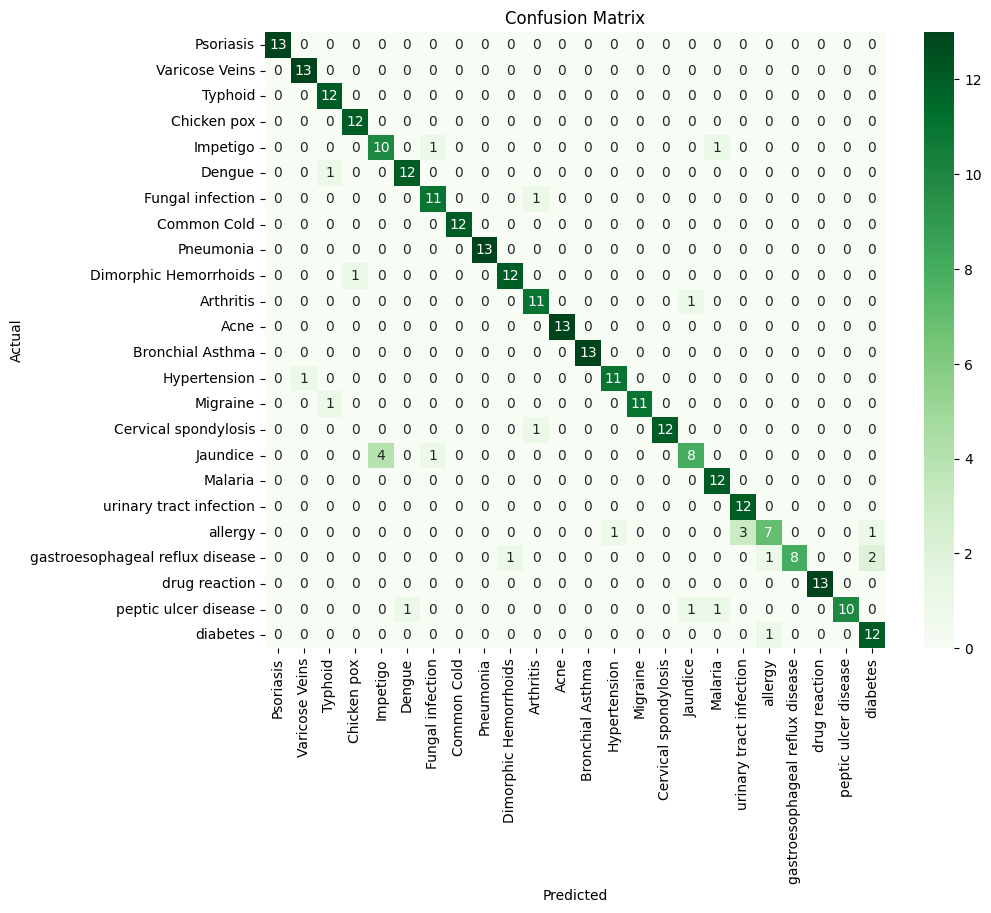

In [109]:
#Import Modules
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Plotting confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=df['label'].unique(), yticklabels=df['label'].unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## **Example #1**

In [136]:
#Import Modules
from sklearn.feature_extraction.text import TfidfVectorizer

# Example Usage
example_symptom_1 = df_mt['clean_keywords'][16]

# Preprocess the input symptom
preprocessed_symptom = preprocess_text(example_symptom_1)

# Transform the preprocessed symptom using the same vectorizer used during training
#symptom_tfidf = tfidf_vectorizer.transform([preprocessed_symptom])

# Predict the disease
predicted_disease = knn_classifier.predict(tfIdfMat_reduced)
actual_disease = df_mt['disease'][16]

# Print the results
print(f'Symptoms: {example_symptom_1}')
print(f'Predicted Disease: {predicted_disease[0]}')
print(f'Actual Disease: {actual_disease}')

Symptoms: pain lower right abdomennauseavomitingfever
Predicted Disease: Psoriasis
Actual Disease: appendicitis


## **Example #2**

In [134]:
#Import Modules
from sklearn.feature_extraction.text import TfidfVectorizer

# Example Usage
example_symptom_1 = "high fever"

# Preprocess the input symptom
preprocessed_symptom = preprocess_text(example_symptom_1)

# Transform the preprocessed symptom using the same vectorizer used during training
#symptom_tfidf = tfidf_vectorizer.transform([preprocessed_symptom])

# Predict the disease
predicted_disease = knn_classifier.predict(tfIdfMat_reduced)
#actual_disease = df_mt['disease'][16]

# Print the results
print(f'Symptoms: {example_symptom_1}')
print(f'Predicted Disease: {predicted_disease[105]}')
#print(f'Actual Disease: {actual_disease}')

Symptoms: high fever
Predicted Disease: Typhoid
